In [1]:
import sys, os
sys.path.append(os.pardir)
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [25]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### Make function

In [26]:
def load_image_into_numpy_array(path):
    image = None
    if path.startswith('http'):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))
    
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (1, im_height, im_width, 3)).astype(np.uint8)

ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : './models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

### Loading label map data

In [27]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Select model

In [28]:
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512'
model_handle = ALL_MODELS[model_display_name]

print(f'Selected model: {model_display_name}')
print(f'Model Handle at TensorFlow hub: {model_handle}')

Selected model: CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1


### Loading model

In [29]:
print('loading model ...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model ...


model loaded!


### Load Image

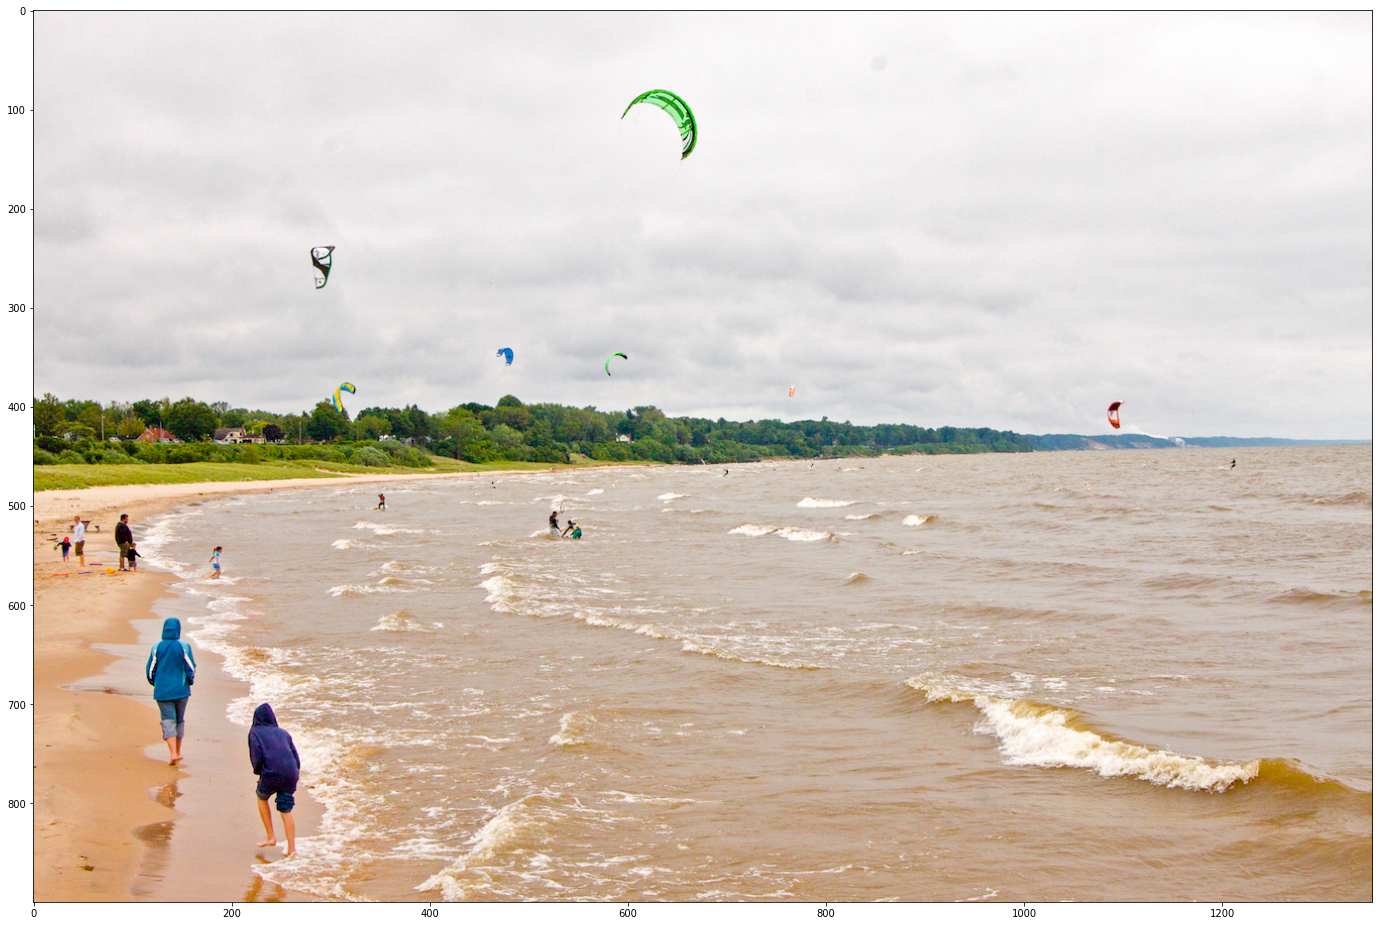

In [30]:
selected_image = 'Beach' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False
convert_image_to_grayscale = False

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

### Start Prediction

In [31]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key: value.numpy() for key, value in results.items()}
print(result.keys())

dict_keys(['num_detections', 'detection_boxes', 'detection_classes', 'detection_keypoint_scores', 'detection_keypoints', 'detection_scores'])


### Visualization Result

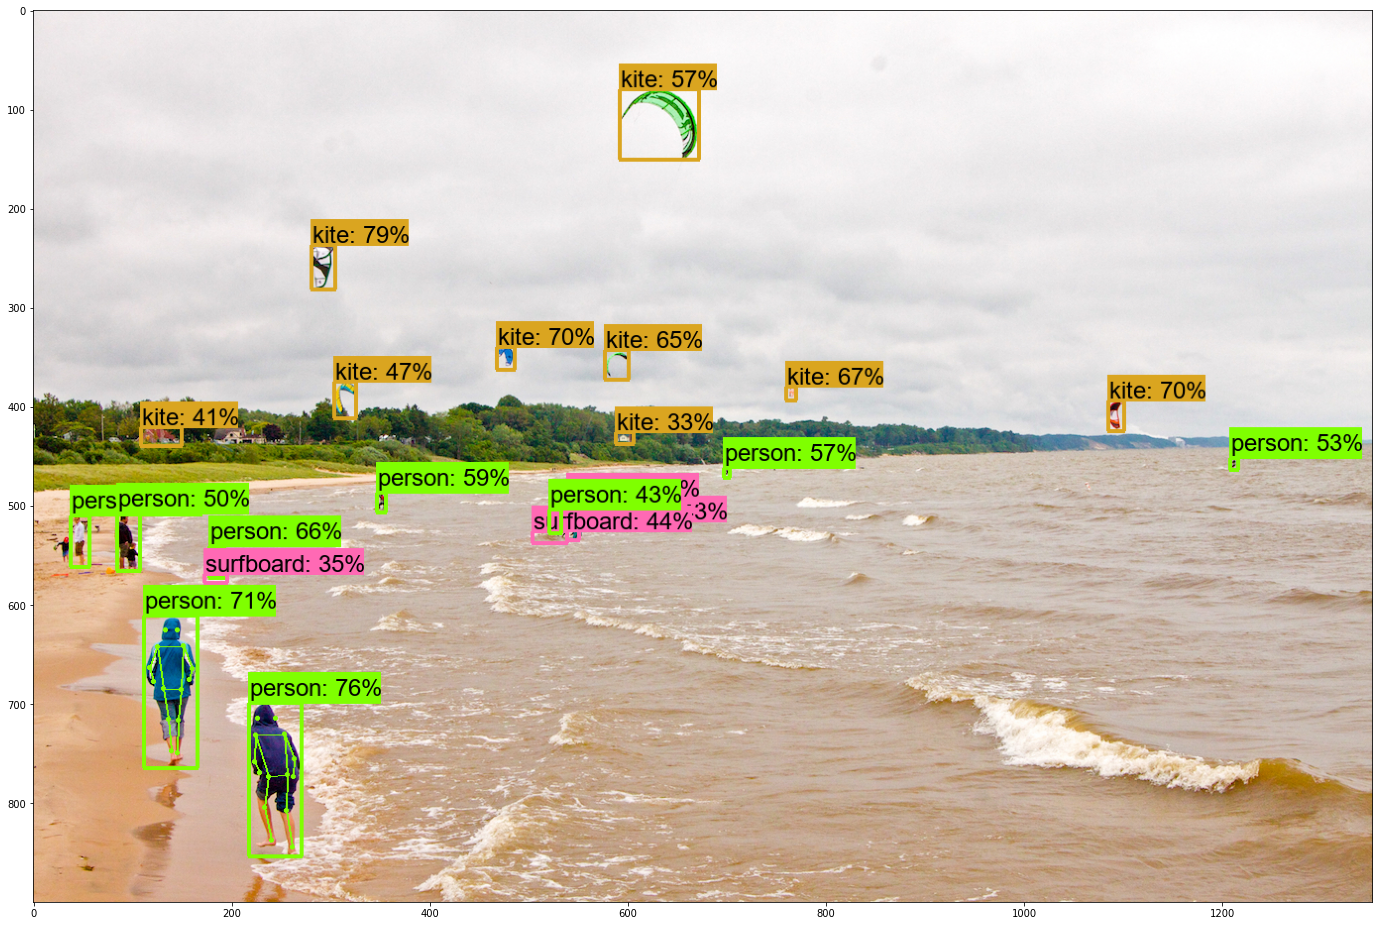

In [34]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoing_scores = None, None
if 'detection_keypoints' in result:
    keypoints = result['detection_keypoints'][0]
    keypoint_scores = result['detection_keypoint_scores'][0]

vis_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections[0],
    result['detection_boxes'][0],
    (result['detection_classes'][0] + label_id_offset).astype(int),
    result['detection_scores'][0],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=.30,
    agnostic_mode=False,
    keypoints=keypoints,
    keypoint_scores=keypoint_scores,
    keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24, 32))
plt.imshow(image_np_with_detections[0])
plt.show()

### Options (Segmentation)

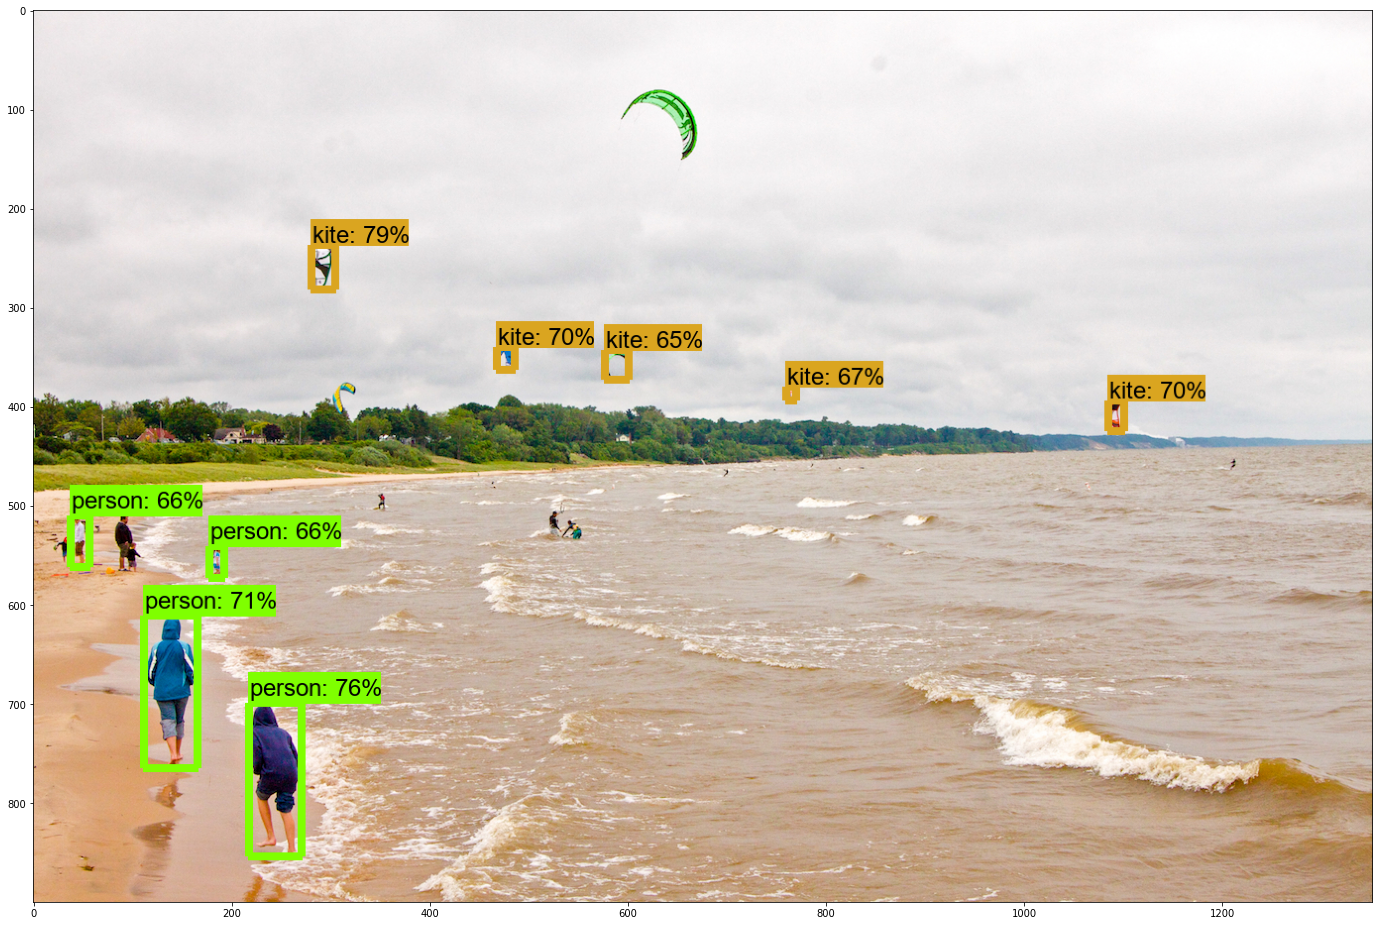

In [37]:
# Handle models with masks
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
    # We need to convert np.arrays to tensors
    detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
    detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

    # Reframe the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
        detection_masks, detection_boxes,
        image_np.shape[1], image_np.shape[2])
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)

    result['detection_masks_reframed'] = detection_masks_reframed.numpy()

vis_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_mask[0],
    result['detection_boxes'][0],
    (result['detection_classes'][0] + label_id_offset).astype(int),
    result['detection_scores'][0],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=.60,
    agnostic_mode=False,
    instance_masks=result.get('detection_masks_reframed', None),
    line_thickness=8)

plt.figure(figsize=(24, 32))
plt.imshow(image_np_with_mask[0])
plt.show()
